# Student Name: Ferreira da Silva LUCAS
# Student No.: 2311328
# Laboratory: Optical Media Interface Lab

# Assignment #1: Statistical Shape Model – Can we guess age and sex from pelvic shape? 

## 1.1: Shape visualization and calculation of average shape

STEP 1: Load some patient pelvic shapes from the data folder and visualize the shapes. (Note: all the shapes are
represented by a triangle mesh with the same number of vertices and same topology)

STEP 2: Next, calculate and visualize the mean shape for each age group from the 20s to 80s and for each gender (i.e.,
7 age groups × 2 gender = 14 categories, 20 subjects each). The mean shape can be calculated by the mean value of the vertex coordinates of each shape.

- Lucas Ferreira
- Date: 2023/12/23

For the STEP 1 we will load and vizualize some data to understand the dataset contents and format. We will be using PyVista (https://docs.pyvista.org/version/stable/) for this step because it has friendly interface and good graphics for .vtk data. The loading code was based on the examples from PyVista documentation (https://docs.pyvista.org/version/stable/user-guide/simple.html).

In [1]:
# Lucas - 2023/12/23
# All imports go here

# Standard library imports
import os
import sys
import pickle
import random
from collections import defaultdict

# Third-party imports for data handling and scientific computing
import numpy as np
import pandas as pd
# from scipy.spatial import distance, cKDTree
from scipy.stats import norm, randint as sp_randint, skew, kurtosis#, uniform

# Machine learning and data preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV#,GridSearchCV,  
# from sklearn.svm import SVR, LinearSVR, SVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.preprocessing import MinMaxScaler#, StandardScaler, Normalizer

# Deep learning with TensorFlow and Keras
# from tensorflow.keras import layers, models, Input
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt

# Image processing
# import cv2

# Misc
from tqdm import tqdm
import torch
# from scipy.optimize import minimize

# PyVista for 3D plotting and mesh analysis
import pyvista as pv
pv.set_jupyter_backend('static')  # Set PyVista backend to 'static'

# Set TensorFlow GPU Allocator Environment Variable
os.environ['TF_GPU_ALLOCATOR'] = ''

In [2]:
# Lucas - 2023/12/23
# Helper functions here

def load_data_from_pickle(file_path):
    """
    Simple function to load a pickle file. I will use it to load the 
    patient_data_list once it is stored in this format.
    Based on: https://stackoverflow.com/questions/35067957/how-to-read-pickle-file
    """
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def set_camera_view_position(plotter, view='y'):
    """
    Lucas - 2023/12/23
    For some reason I don't understand, PyVista doen't render the plots in a standar view, so,
    in order to make the same frontal (Y) view as the images shown in the class powerpoint
    I manually changed the camera position to account for this camera movement.
    I followed the instructions from the documentation below
    Source: https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.camera_position.html
    
    Args:
        plotter (object): A plotter object that will have the camera_position modified

    Returns:
        None, just chagnes camera position to make clearer and equal view across all images
    """
    if view == 'x':
        plotter.camera_position = [(701.5765344548439, 2.640510368347165, 1.4287771224975572),
                                    (0.3748994827270451, 2.640510368347165, 1.4287771224975572),
                                    (0.0, 0.0, 1.0)]
    elif view == 'y':
        plotter.camera_position = [(0.3748994827270451, -698.5611246037697, 1.4287771224975572),
                                    (0.3748994827270451, 2.640510368347165, 1.4287771224975572),
                                    (0.0, 0.0, 1.0)]

    elif view == 'z':
        plotter.camera_position = [(0.3748994827270451, 2.640510368347165, 702.6304120946144),
                                    (0.3748994827270451, 2.640510368347165, 1.4287771224975572),
                                    (0.0, 1.0, 0.0)]

    elif view == 'perspective':
        plotter.camera_position = [(405.2138521900845, 407.4794630757046, 406.26772982985494),
                                    (0.3748994827270451, 2.640510368347165, 1.4287771224975572),
                                    (0.0, 0.0, 1.0)]

    elif view == 'pca_x':
        plotter.camera_position = [(698.9851892929001, 2.019756317138672, 0.6651420593261719),
                                    (-0.34275054931640625, 2.019756317138672, 0.6651420593261719),
                                    (0.0, 0.0, 1.0)]
        
    elif view == 'pca_y':
        plotter.camera_position = [(-0.34275054931640625, -697.3081835250779, 0.6651420593261719),
                                    (-0.34275054931640625, 2.019756317138672, 0.6651420593261719),
                                    (0.0, 0.0, 1.0)]
        
    elif view == 'pca_z':
        plotter.camera_position = [(-0.34275054931640625, 2.019756317138672, 699.9930819015427),
                                    (-0.34275054931640625, 2.019756317138672, 0.6651420593261719),
                                    (0.0, 1.0, 0.0)]
        
    elif view == 'pca_perspective':
        plotter.camera_position = [(403.4144237704138, 405.7769306368689, 404.4223163790564),
                                    (-0.34275054931640625, 2.019756317138672, 0.6651420593261719),
                                    (0.0, 0.0, 1.0)]
        
def load_patient_data(csv_path, vtk_folder_path):
    """
    Lucas - 2023/12/23
    Load patient pelvic shapes from the specified data folder and visualize the shapes.
    
    Args:
        csv_path (str): Path to the CSV file containing a list of file IDs, sex, and gender.
        vtk_folder_path (str): Path to the folder containing all VTK files.

    Returns:
        List[dict]: A list of dictionaries, where each dictionary contains data for one patient.
    """
    patient_csv_data = pd.read_csv(csv_path)
    patient_data_list = []

    for index, row in tqdm(patient_csv_data.iterrows(), desc='Loading patient data', total=patient_csv_data.shape[0]):
        patient_id = row['ID']
        vtk_file_path = os.path.join(vtk_folder_path, f"{patient_id}.vtk")
        mesh = pv.read(vtk_file_path)

        patient_data_list.append({
            'id': patient_id,
            'mesh': mesh,
            'sex': row['PatientSex'],
            'age': row['PatientAge'],
        })

    print(f'Finished loading {patient_csv_data.shape[0]} patients data.')
 
    return patient_data_list

def render_patient_mesh(patient_data_dict):
    """
    Lucas - 2023/12/23
    Render a mesh for a patient with PyVista and set the title to include patient's ID, sex, and age.
    Path example: "../Assignment1/pelvis_dataset/Patient_0001.vtk"
    
    Args:
        patient_data (dict): A dictionary containing patient's data. Expected keys are 'id', 'mesh', 'sex', and 'age'.
    
    Returns:
        None, jut plot the mesh
    """
    # Lucas - 2023/12/23

    mesh = patient_data_dict['mesh']
    patient_id = patient_data_dict['id']
    sex = patient_data_dict['sex']
    age = patient_data_dict['age']

    # Create a PyVista plotter
    # Based on the tutorial on PyVista docs: 
    # https://docs.pyvista.org/version/stable/user-guide/simple.html#plotting
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, show_edges=False, color='white')
    set_camera_view_position(plotter, view='y')
    
    # Set the title for our plot
    title = f"Patient ID: {patient_id}, Sex: {sex}, Age: {age}"
    plotter.add_title(title)

    # Show the plot
    plotter.show()
    # Save image
    # Based on https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.image_scale.html
    plotter.screenshot(f'../OUTPUT/assignemnt_1_1_sample_patient_{patient_id}_{sex}_{age}.png') 

In [3]:
# Lucas - 2023/12/23
# Load mesh data
# If it is the first time, save the data so we 
# don't need to load again (Takes some time to process)

vtk_folder_path = "../Assignment1/pelvis_dataset/"
csv_file_path = os.path.join(vtk_folder_path, "PatientID_list_training.csv")
pickle_file = '../OUTPUT/patient_data_list.pkl'  # Path to the pickle file

# Check if the pickle file exists
if os.path.exists(pickle_file):
    print("Loading data from pickle file.")
    patient_data_list = load_data_from_pickle(pickle_file)
else:
    print("Pickle file not found. Processing VTK meshes.")
    patient_data_list = load_patient_data(csv_file_path, vtk_folder_path)

    # Save the processed data to a pickle file for future use
    with open(pickle_file, 'wb') as file:
        pickle.dump(patient_data_list, file)

Loading data from pickle file.


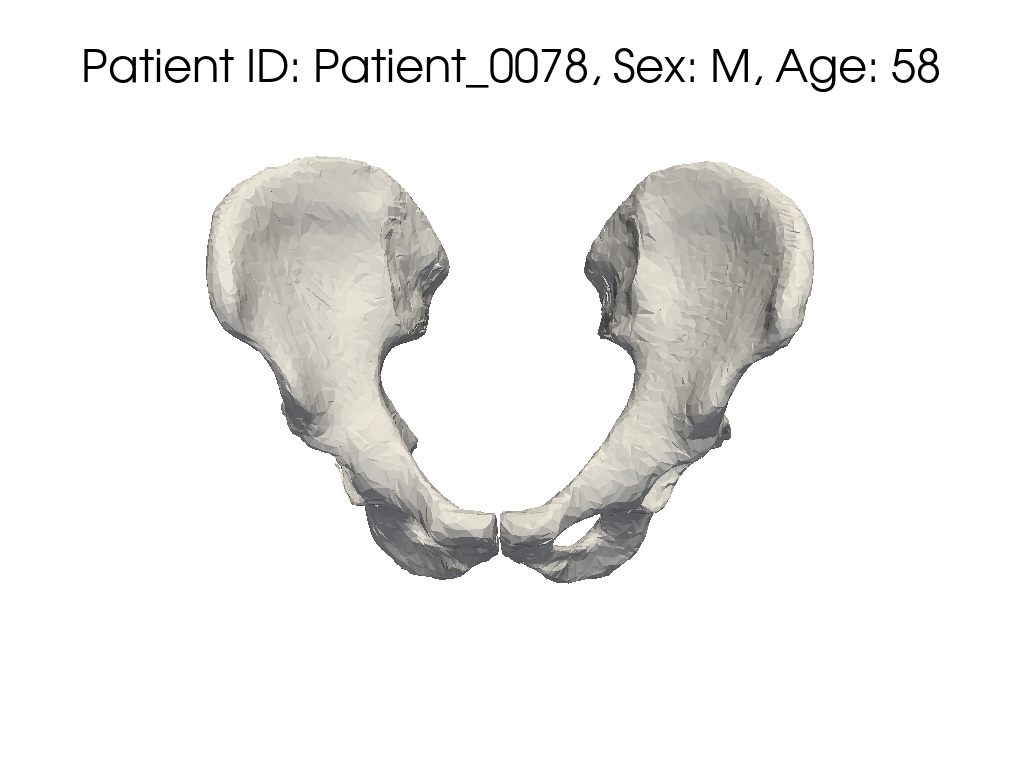

In [4]:
# Lucas - 2023/12/23
# Render one sample for checking
render_patient_mesh(patient_data_list[77])

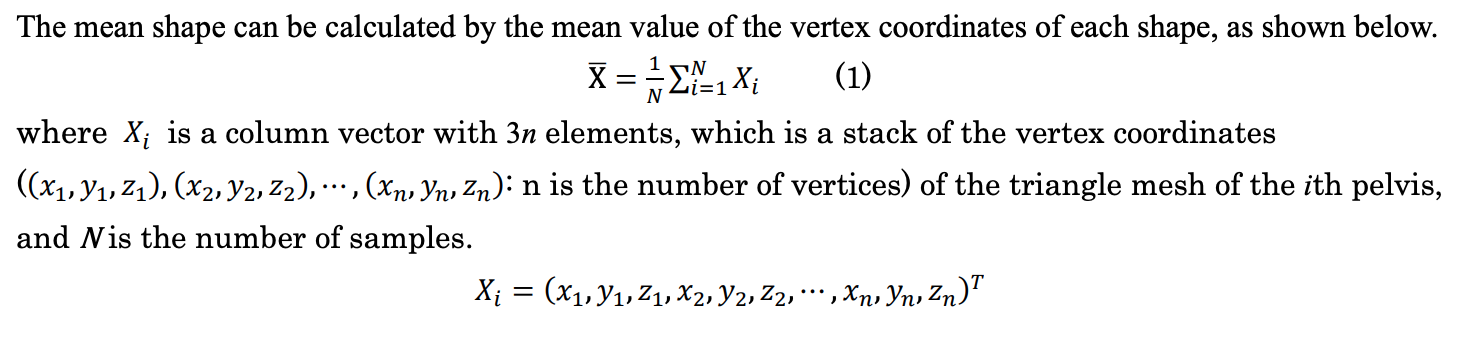

In [5]:
# Lucas - 2023/12/23
# In this part we prepare data to compute the average shape in the next cell

n_vertices = 9996  # Number of vertices per mesh

# Group meshes by age groups and sex
# We will populate a dictionary with dictionary of list
# dict grouped_meshes -> dict with age groups and sex -> list of same sex and age group patients
# Based on: https://docs.python.org/3/library/collections.html#collections.defaultdict
grouped_meshes = defaultdict(lambda: defaultdict(list))
for patient in patient_data_list:
    age_group = f"{(patient['age'] // 10) * 10}s"
    grouped_meshes[age_group][patient['sex']].append(patient['mesh'])

# Process the grouped meshes and calculate the averaged mesh for each group
# We will also store area and volume for each surface for it can be useful for training
averaged_patient_meshes = {}
std_areas = {}
std_volumes = {}

# Iterate based on gender and age group
for age_group, sex_group in grouped_meshes.items():
    # Take the data for gender and mesh
    for sex, meshes in sex_group.items():
        # Initialize an array to store all vertices for the current group
        all_vertices = np.zeros((n_vertices, 3, len(meshes)))
        all_volumes = np.zeros((1, 1, len(meshes)))
        all_areas = np.zeros((1, 1, len(meshes)))

        # Store data of each mesh in the array for each patient of same sex/age group
        for i, mesh in enumerate(meshes):
            all_vertices[:, :, i] = mesh.points
            all_volumes[:, :, i] = mesh.volume
            all_areas[:, :, i] = mesh.area

        # Calculate the mean vertices to get the mean shape
        mean_vertices = np.mean(all_vertices, axis=2)
        std_vol = np.std(all_volumes, axis=2).squeeze()
        std_area = np.std(all_areas, axis=2).squeeze()

        # Create a new PolyData object using the mean vertices
        # Assuming all meshes have the same connectivity, we can use the faces from the first mesh
        key = (age_group, sex)
        averaged_patient_meshes[key] = pv.PolyData(mean_vertices, meshes[0].faces)
        std_areas[key] = std_area
        std_volumes[key] = std_vol

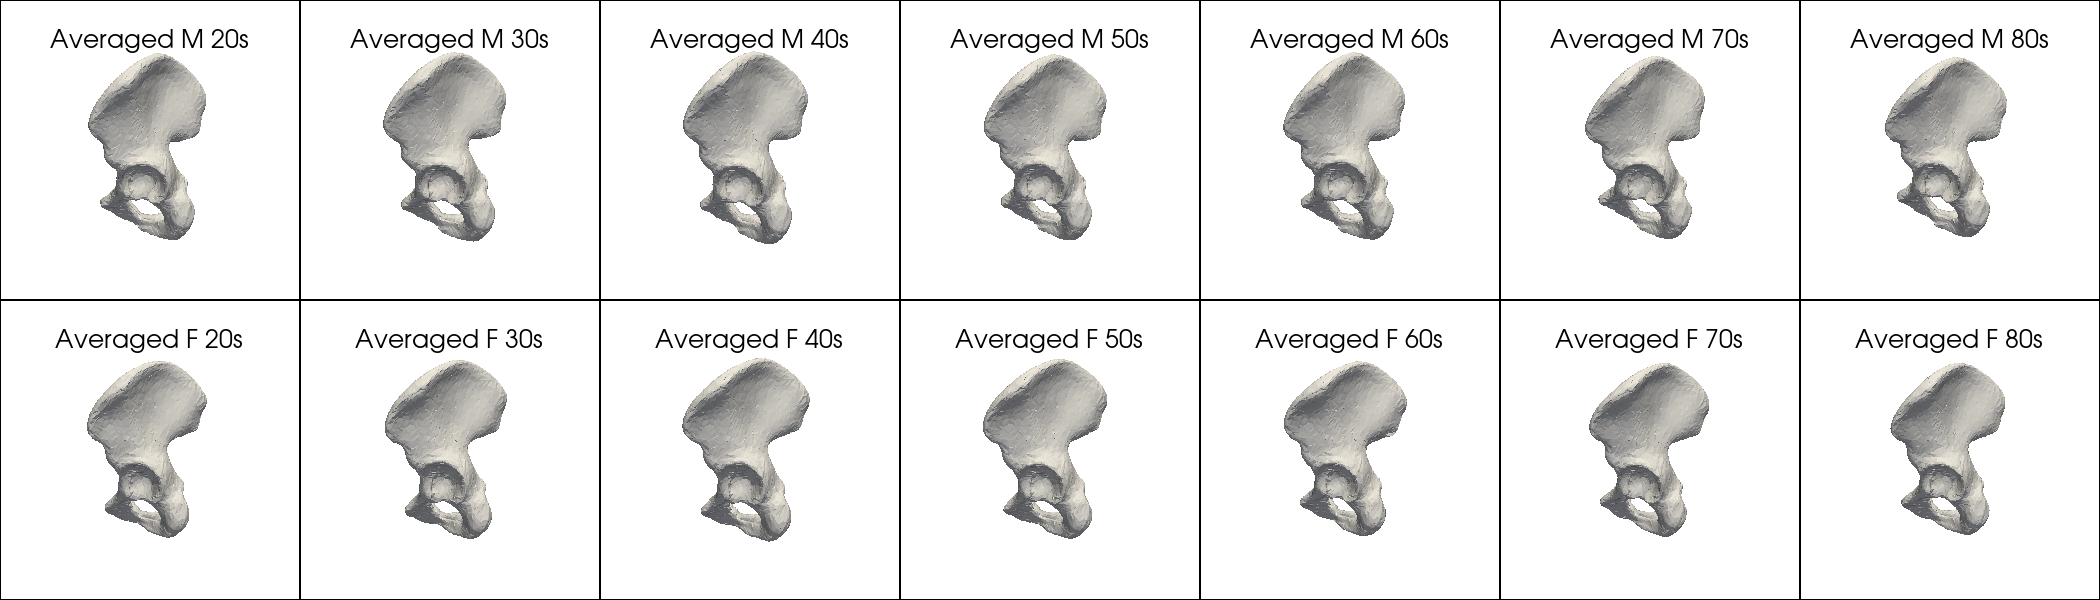

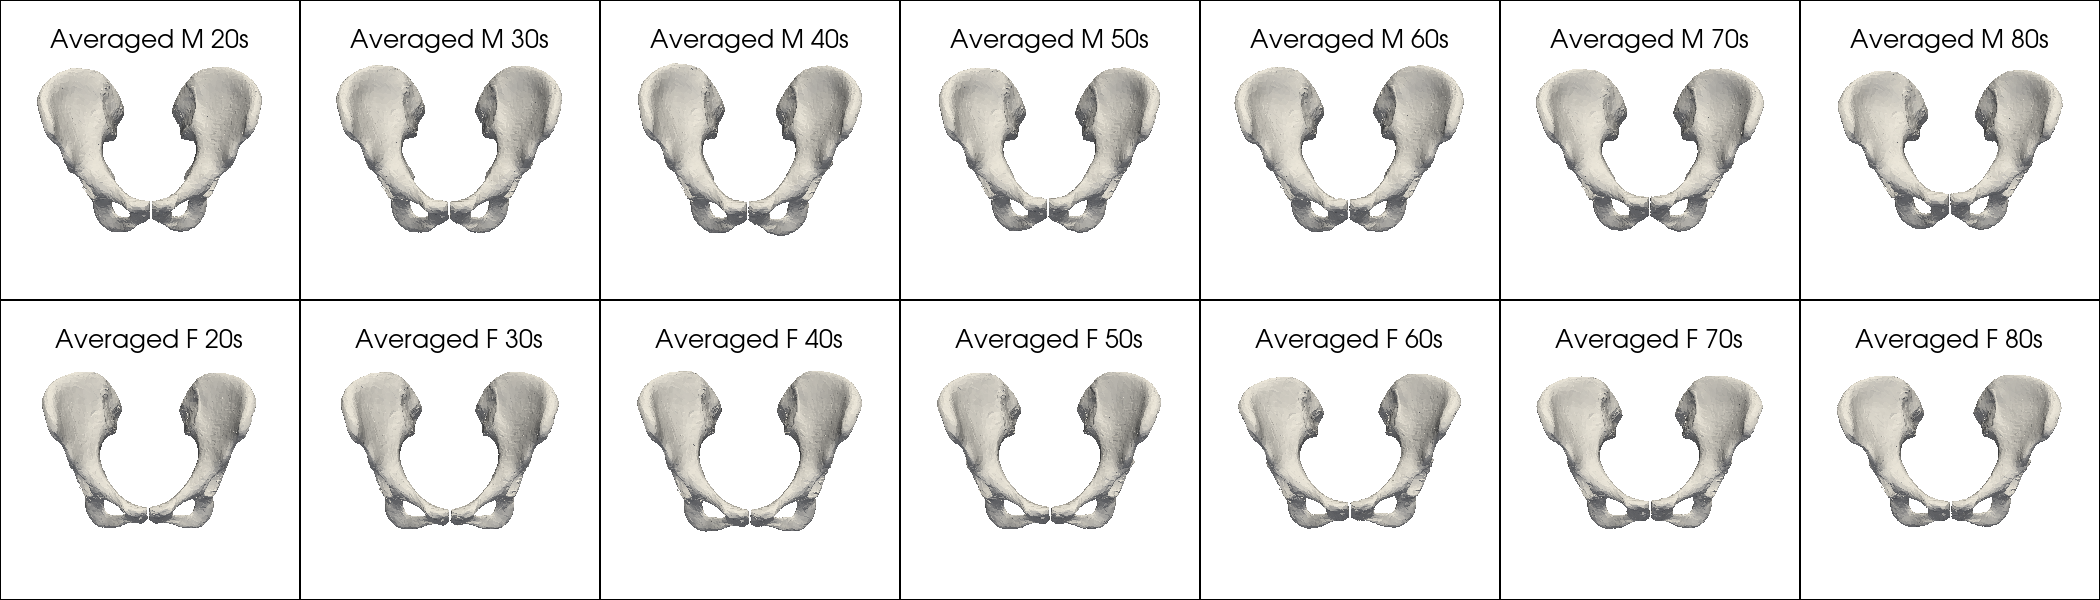

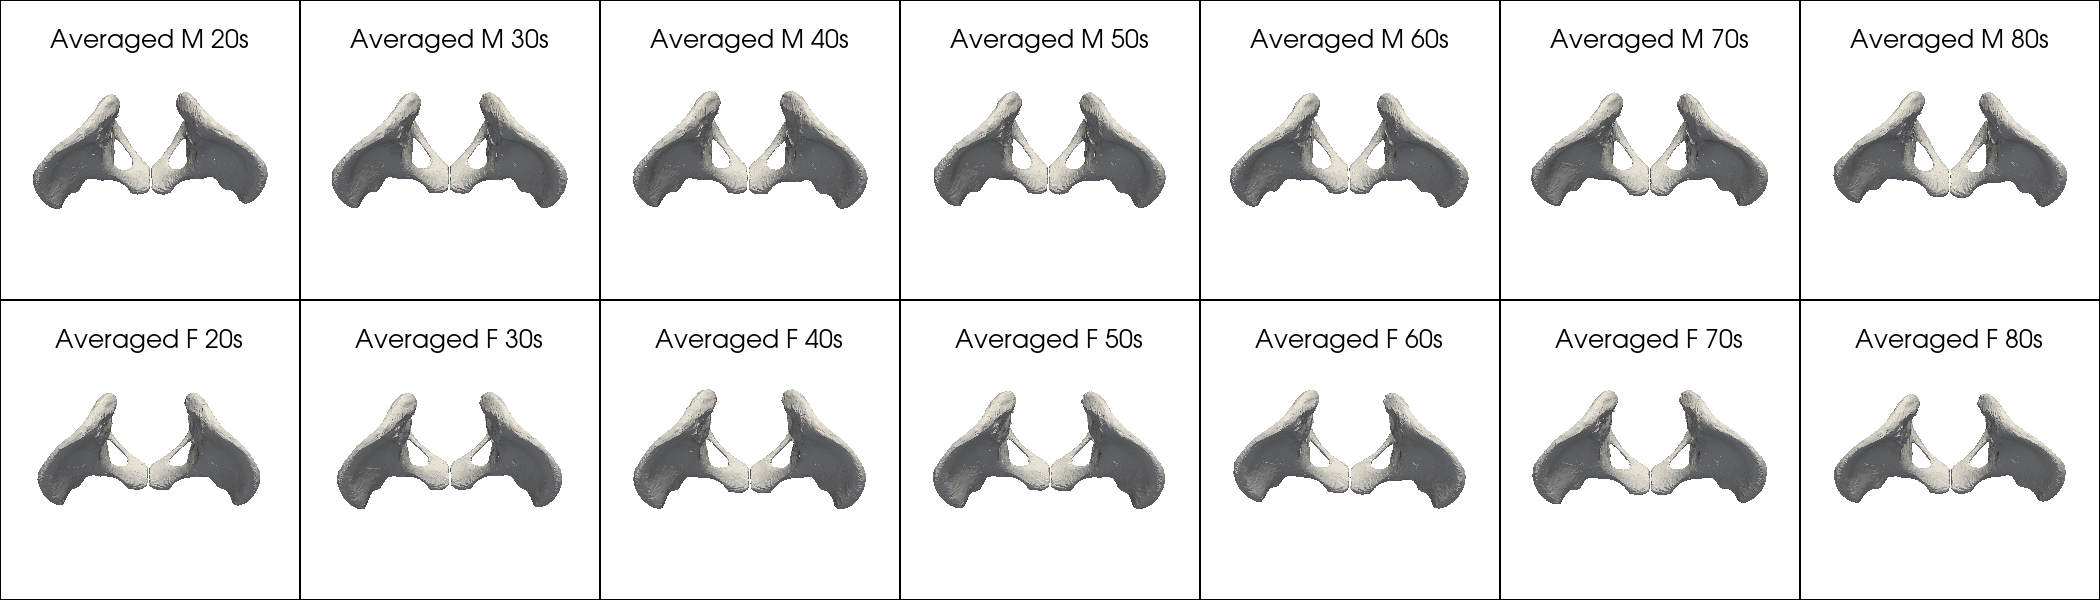

Plof finished and images saved to OUTPUT folder.


In [6]:
# Lucas - 2023/12/23
# Define age groups
age_groups = ['20s', '30s', '40s', '50s', '60s', '70s', '80s']

# First row for male, second row for female
for camera_view in ['x', 'y', 'z']:

    # Create a PyVista plotter with 7 columns and 2 rows
    plotter = pv.Plotter(shape=(2, 7), window_size=(2100, 600))

    # Iterage over rows for gender
    for row, sex in enumerate(['M', 'F']):
        # Iterate over cols for age
        for col, age_group in enumerate(age_groups):
            key = (age_group, sex)
            if key in averaged_patient_meshes:
                mesh = averaged_patient_meshes[key]
                # Based on: https://docs.pyvista.org/version/stable/api/plotting/plotting
                plotter.subplot(row, col)
                plotter.add_mesh(mesh, color='white', show_edges=False)
                set_camera_view_position(plotter, view=camera_view)
                plotter.add_title(f"Averaged {sex} {age_group}", font_size=10)
    
    # Show the plotter and save screenshot
    plotter.show()
    plotter.screenshot(f'../OUTPUT/assignemnt_1_1_averaged_shapes_{camera_view}.png')
    plotter.close()
    
print(f"Plof finished and images saved to OUTPUT folder.")

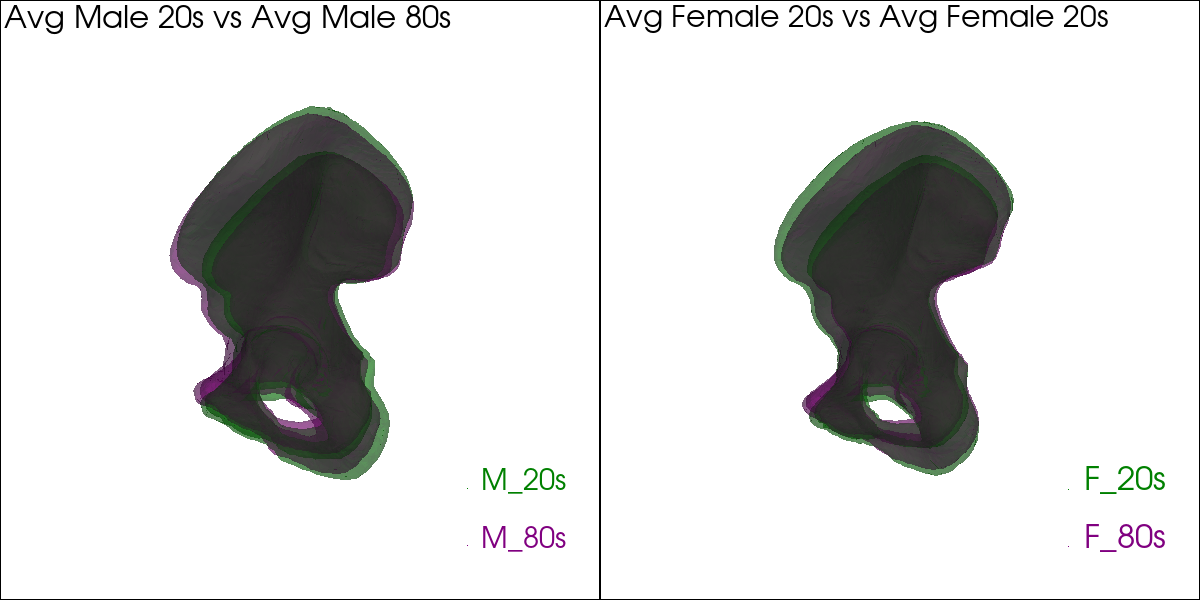

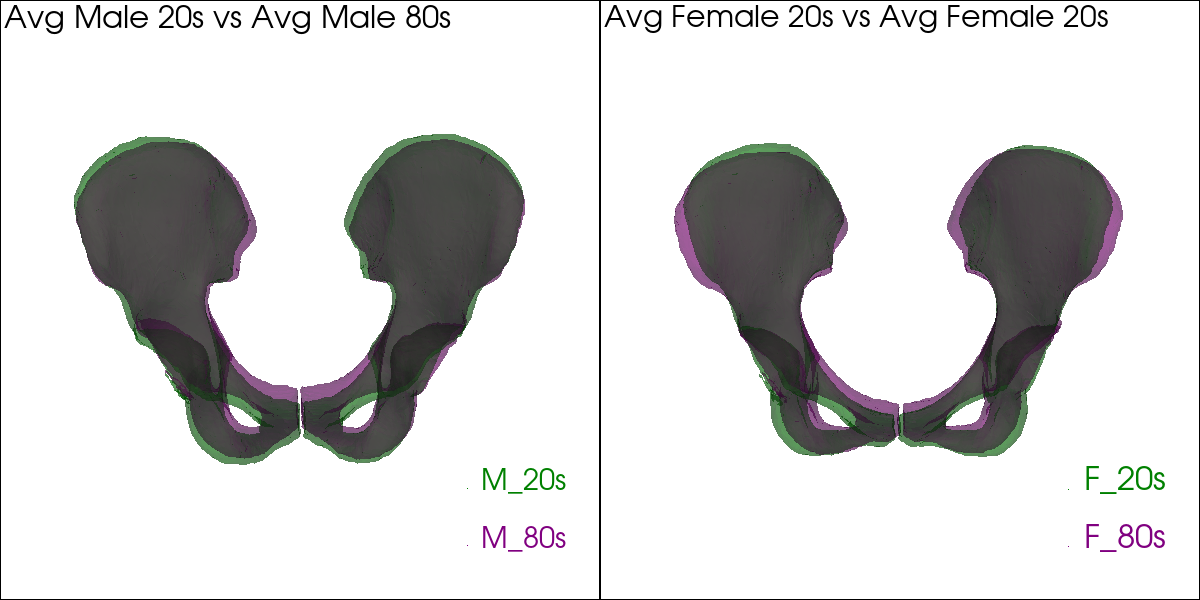

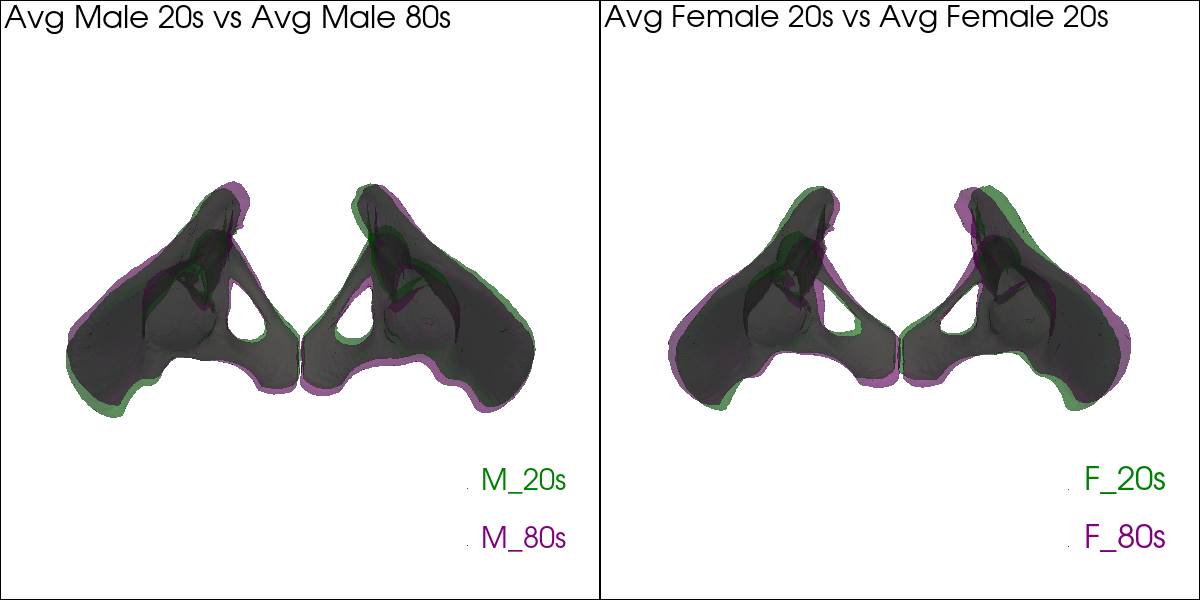

In [7]:
# Lucas - 2023/12/23
# First row for male, second row for female
# Plot some overlays of shapes for visula inspection
# Based on: https://docs.pyvista.org/version/stable/api/plotting/plotting

for camera_view in ['x', 'y', 'z']:
        
    # Create a new plotter
    plotter = pv.Plotter(shape=(1, 2), window_size=(1200, 600))

    # Comparison 1: Male 20s overlaid with Male 80s
    plotter.subplot(0, 0)
    plotter.add_mesh(averaged_patient_meshes[('20s', 'M')], color='green', opacity=0.4, label='M_20s')
    plotter.add_mesh(averaged_patient_meshes[('80s', 'M')], color='purple', opacity=0.4, label='M_80s')
    plotter.add_legend(bcolor='w', face=None, loc='lower right')
    set_camera_view_position(plotter, view=camera_view)
    plotter.add_text("Avg Male 20s vs Avg Male 80s")
    
    # Comparison 2: Female 20s overlaid with Female 80s
    plotter.subplot(0, 1)
    plotter.add_mesh(averaged_patient_meshes[('20s', 'F')], color='green', opacity=0.4, label='F_20s')
    plotter.add_mesh(averaged_patient_meshes[('80s', 'F')], color='purple', opacity=0.4, label='F_80s')
    plotter.add_legend(bcolor='w', face=None, loc='lower right')
    set_camera_view_position(plotter, view=camera_view)
    plotter.add_text("Avg Female 20s vs Avg Female 20s")
    
    # Show the plotter and save screenshot
    plotter.show()
    plotter.screenshot(f'../OUTPUT/assignemnt_1_1_overlay_{camera_view}.png')
    plotter.close()

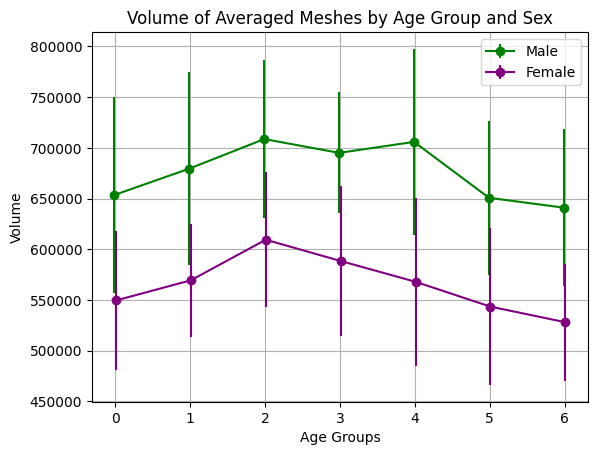

In [40]:
# First subplot for volumes
plt.errorbar(x_positions - offset, male_volumes, yerr=std_volumes_male, label='Male', color='green', fmt='-o')
plt.errorbar(x_positions + offset, female_volumes, yerr=std_volumes_female, label='Female', color='purple', fmt='-o')
plt.xlabel('Age Groups')
plt.ylabel('Volume')
plt.title('Volume of Averaged Meshes by Age Group and Sex')
plt.xticks(x_positions)
plt.legend()
plt.grid(True)
plt.savefig(f'../OUTPUT/assignemnt_1_1_volume_age_group.png', dpi=300)
plt.show()

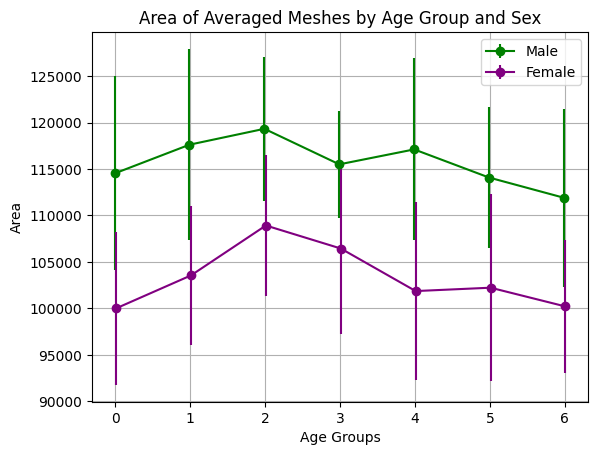

In [41]:
# Second subplot for areas
plt.errorbar(x_positions - offset, male_areas, yerr=std_areas_male, label='Male', color='green', fmt='-o')
plt.errorbar(x_positions + offset, female_areas, yerr=std_areas_female, label='Female', color='purple', fmt='-o')
plt.xlabel('Age Groups')
plt.ylabel('Area')
plt.title('Area of Averaged Meshes by Age Group and Sex')
plt.xticks(x_positions)
plt.legend()
plt.grid(True)
plt.savefig(f'../OUTPUT/assignemnt_1_1_area_age_group.png', dpi=300)
plt.show()

# 1.2: Principal Component Analysis (PCA) of shape and visualization of variation

- STEP 3
- Perform a principal component analysis on A and visualize the shape variation in the direction of the first and second principal components.

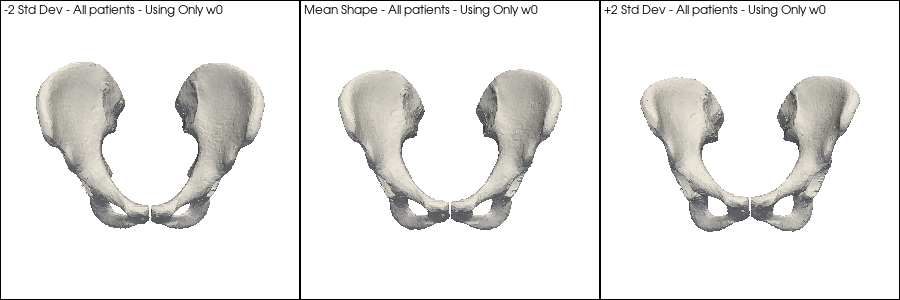

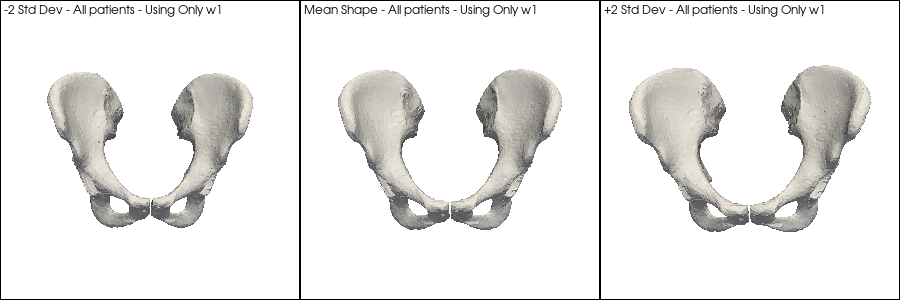

In [9]:
# Lucas - 2023/12/26
# Perform PCA on the dataset

def preprocess_data_for_pca(patient_data_list, num_components=2):
    # Flatten the mesh data into a matrix
    # PCA in scikit-learn can't receive a matrix
    all_meshes = []
    for patient in patient_data_list:
        mesh = patient['mesh']
        points = mesh.points
        flattened_points = points.flatten()
        all_meshes.append(flattened_points)
    
    # Stack all flattened meshes to create the data for PCA
    A = np.column_stack(all_meshes)
    
    # Perform PCA
    # Based on: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    # And on: https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
    pca = PCA(n_components=num_components)
    pca.fit(A.T)  # Transpose to have samples as rows
    mean_shape = pca.mean_
    components = pca.components_
    variances = pca.explained_variance_

    # Lucas - 2023/12/29
    # Reconstruct the shapes at mean +- standard deviations along the first PC
    # we can use w0 and w1 as knobs at each time to check the impact of each one
    for w in [0, 1]:
        for sigma in [2]:
            std_dev = np.sqrt(variances[w])
            shapes = {
                f'-{sigma}_std_dev w{w}': mean_shape - sigma * std_dev * components[w],
                'mean': mean_shape,
                f'+{sigma}_std_dev w{w}': mean_shape + sigma * std_dev * components[w],
            }
        
            # Create a PyVista plotter for subplot visualization
            plotter = pv.Plotter(shape=(1, 3), window_size=(900, 300))
            
            # Visualize the mean shape and the variations
            titles = [f'-{sigma} Std Dev - All patients - Using Only w{w}',\
                      f'Mean Shape - All patients - Using Only w{w}',\
                      f'+{sigma} Std Dev - All patients - Using Only w{w}']
            for i, (key, shape_vector) in enumerate(shapes.items()):
                # Reshape the vector back to the original mesh shape
                reshaped_points = shape_vector.reshape((-1, 3))
                # Create a PyVista mesh for visualization
                mesh = pv.PolyData(reshaped_points, patient_data_list[0]['mesh'].faces)
                # Add the mesh to the plotter
                plotter.subplot(0, i)
                plotter.add_mesh(mesh, color='white', show_edges=False)
                set_camera_view_position(plotter, view= 'pca_y')
                plotter.add_text(titles[i], font_size=10)
            
            # Show the plotter and save screenshot
            plotter.show()
            plotter.screenshot(f'../OUTPUT/assignemnt_1_1_pca_variation_sig_{sigma}_w{w}.png')
            plotter.close()
            
    # Return the PCA object, mean shape, and principal components for further use
    return pca, mean_shape, components

pca, mean_shape, components = preprocess_data_for_pca(patient_data_list, num_components=2)

## 1.3: Estimation of age and gender from pelvic shape

### Using the pelvic shape, age, and gender of the given 280 subjects (Patient_0000.vtk to Patient_0280.vtk) as a training dataset, estimate the age and gender of the 100 subjects (Patient_0281.vtk to Patient_0380.vtk) for which we only know the shape. You can use any machine learning algorithm and any existing tool. Please save the estimation results in the same format as “PatientID_list_training.csv” (i.e., comma-separated, one line per patient, “PatientID, PatientSex, PatientAge”. 

In [10]:
# Lucas - 2023/01/03
# The next parts execute the training steps to predict gender and age from pelvis data
# Steps:
# 1 - Extract mesh features from the mesh data (selected features I though would benefit training).
# based on: 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html
# https://stackoverflow.com/questions/29095724/rolling-statistics-on-image-python
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
# 2 - Normalize volumes, areas and ages to make it easier for model predict
# 3 - Train model for gender classification
# 4 - Train intermediary model for age group classification
# 5 - Train model for age regression
# 6 - Plot results of each model in the test data
# 7 - Use the trained models to make predictions in the new data

def extract_mesh_features(meshes):
    features = []
    for mesh in meshes:
        # Assuming mesh.vertices is a numpy array of shape (n_vertices, 3)
        vertices = np.array([vertex for vertex in mesh.points])

        # Basic statistical features
        mean_vertices = np.mean(vertices, axis=0)
        max_vertices = np.max(vertices, axis=0)
        min_vertices = np.min(vertices, axis=0)
        std_vertices = np.std(vertices, axis=0)
        skew_vertices = skew(vertices, axis=0)
        kurtosis_vertices = kurtosis(vertices, axis=0)

        # Combine features for this mesh
        mesh_features = np.hstack((mean_vertices, max_vertices, min_vertices, std_vertices, skew_vertices, kurtosis_vertices))
        features.append(mesh_features)

    return np.array(features)

# # Data loading code
# Initialize lists
ages, volumes, areas, meshes, y_gender = [], [], [], [], []

# Single loop to collect all data
for entry in patient_data_list:
    ages.append(entry['age'])
    volumes.append(entry['mesh'].volume)
    areas.append(entry['mesh'].area)
    meshes.append(entry['mesh'])
    y_gender.append(1 if entry['sex'] == 'M' else 0)

# Convert lists to numpy arrays
ages = np.array(ages)
volumes = np.array(volumes)
areas = np.array(areas)
meshes = np.array(meshes)
y_gender = np.array(y_gender)

# Normalizing volumes and areas
volume_scaler = MinMaxScaler()
volumes_scaled = volume_scaler.fit_transform(volumes.reshape(-1, 1))
area_scaler = MinMaxScaler()
areas_scaled = area_scaler.fit_transform(areas.reshape(-1, 1))

# Normalizing age
age_scaler = MinMaxScaler()
y_age_scaled = age_scaler.fit_transform(ages.reshape(-1, 1))

# Extract features from meshes
print(f"Extracting features from meshes")
mesh_features = extract_mesh_features(meshes)
print(f"Finished extracting features from meshes")

Extracting features from meshes
Finished extracting features from meshes


In [11]:
# Lucas - 2023/01/03
# Data preparation for gender classification
X_gender = np.hstack((volumes_scaled, areas_scaled, mesh_features))
y_gender = np.array([1 if entry['sex'] == 'M' else 0 for entry in patient_data_list])

# Splitting the dataset for gender classification model
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gender, y_gender, test_size=0.2)

# Train gender classification model
gender_model = RandomForestClassifier()
gender_model.fit(X_train_g, y_train_g)

# Predictions and evaluation
gender_predictions = gender_model.predict(X_test_g)
gender_accuracy = accuracy_score(y_test_g, gender_predictions)
print(f"Gender Prediction Accuracy: {gender_accuracy}")

Gender Prediction Accuracy: 0.9642857142857143


In [12]:
# Lucas - 2023/01/03
# Data preparation for age group classification
# Create age group labels (20s, 30s, etc.)
def create_age_groups(age):
    return age // 10 * 10

y_age_groups = np.array([create_age_groups(age) for age in ages])

X_age_group = np.hstack((volumes_scaled, areas_scaled, mesh_features, y_gender.reshape(-1, 1)))

# Splitting the dataset for age group classification
X_train_ag, X_test_ag, y_train_ag, y_test_ag = train_test_split(X_age_group, y_age_groups, test_size=0.2)

# Lucas - 2023/01/03
# Define the parameter distributions for RandomForestClassifier
# This helps us find the best model for our data
# based on: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
param_distributions = {
    'n_estimators': sp_randint(100, 500),
    'max_features': ['auto', 'sqrt'],
    'max_depth': sp_randint(10, 50),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 5)
}

# Create a base model for RandomForestClassifier
rfc = RandomForestClassifier()

# Lucas - 2023/01/03
# Instantiate the randomized search model
# Use the search to find the best among the parameters we chose
random_search_rfc = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings sampled
    cv=3, 
    n_jobs=-1, 
    verbose=0, 
    random_state=42
)

# Fit the randomized search to the training data
random_search_rfc.fit(X_train_ag, y_train_ag)

# Use the best model to make predictions
age_group_model = random_search_rfc.best_estimator_
age_group_predictions = age_group_model.predict(X_test_ag)
age_group_accuracy = accuracy_score(y_test_ag, age_group_predictions)
print(f"Age Group Prediction Accuracy (Randomized Search): {age_group_accuracy}")

/Users/lucas-fe/Documents/NAIST/2023/02-fall_semester/ST4100auMultidimensional signal processing/Report 2/tajigenshingo/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
147 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
129 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucas-fe/Documents/NAIST/2023/02-fall_semester/ST4100auMultidimensional signal processing/Report 2/tajigenshingo/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucas-fe/Documents/NAIST/2023/02-fall_semester/ST4100auMultidimensional signal p

Age Group Prediction Accuracy (Randomized Search): 0.2857142857142857


In [13]:
# Lucas - 2023/01/03
# Generate age group predictions for the entire dataset
age_group_predictions_for_age = age_group_model.predict(X_age_group)
age_group_predictions_for_age = age_group_predictions_for_age.reshape(-1, 1)

# Add gender predictions and age group predictions to the feature set for age regression
X_age = np.hstack((volumes_scaled, areas_scaled, mesh_features, y_gender.reshape(-1, 1), age_group_predictions_for_age))

# Splitting the dataset for age regression model
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_age, y_age_scaled, test_size=0.2)

# Lucas - 2023/01/03
# Define the parameter distributions for RandomForestClassifier
# This helps us find the best model for our data
# based on: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
param_distributions = {
    'C': [4.5741367521382434],  # Regularization parameter
    'kernel': ['linear'],  # Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2]  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
}

# Create a base model for SVR
svr = SVR()

# Lucas - 2023/01/03
# Instantiate the randomized search model
# Use the search to find the best among the parameters we chose
random_search_svr = RandomizedSearchCV(
    estimator=svr, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings sampled
    cv=3, 
    n_jobs=-1, 
    verbose=0, 
    random_state=42, 
    scoring='neg_mean_squared_error'
)

# Fit the randomized search to the data
random_search_svr.fit(X_train_a, y_train_a.ravel())

# Use the best model to make predictions
age_model = random_search_svr.best_estimator_
age_predictions = age_model.predict(X_test_a)
age_mse = mean_squared_error(y_test_a, age_predictions)
print(f"Age Prediction MSE (SVR - Randomized Search): {age_mse}")

/Users/lucas-fe/Documents/NAIST/2023/02-fall_semester/ST4100auMultidimensional signal processing/Report 2/tajigenshingo/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Age Prediction MSE (SVR - Randomized Search): 0.02322889780113954


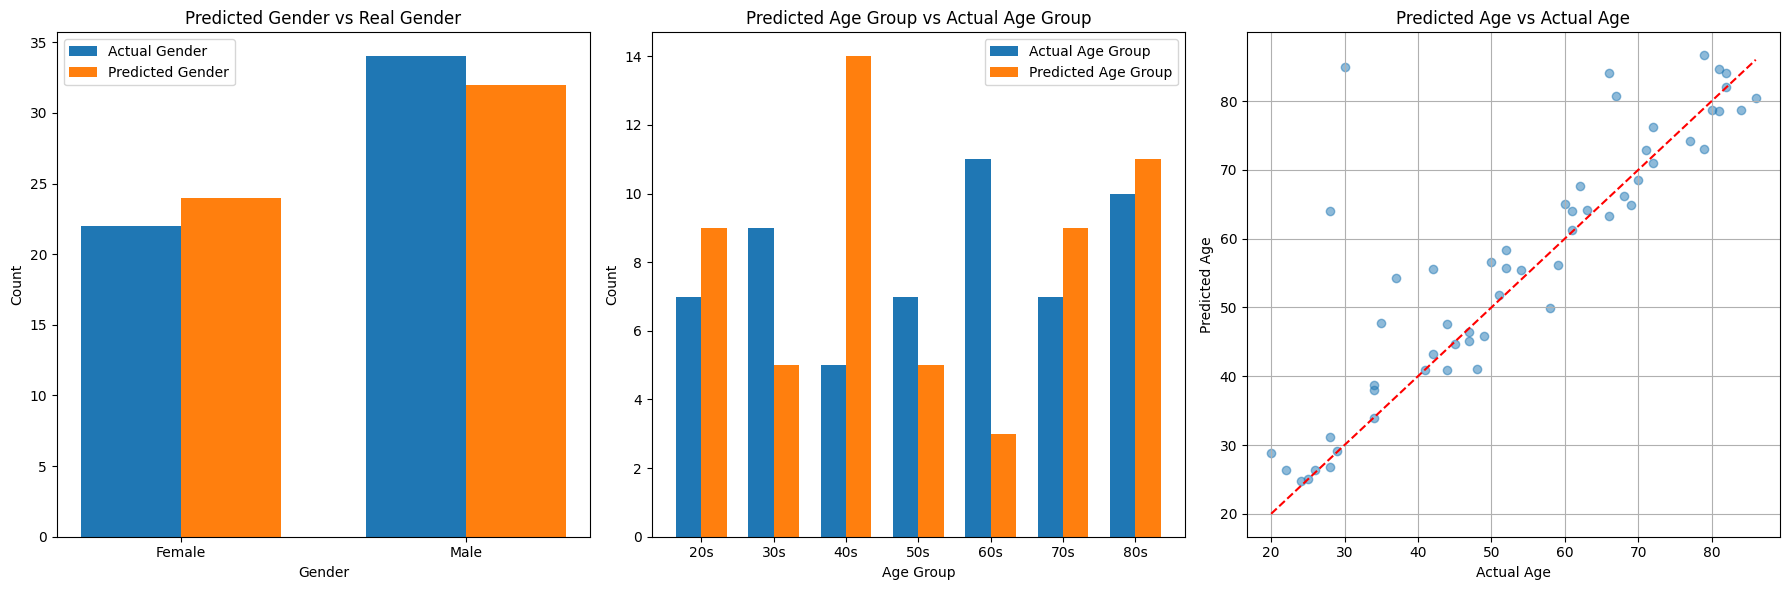

Plof finished and images saved to OUTPUT folder.


In [14]:
# Lucas - 2024/01/03
# Make plots of results in test dataset
# Compute actual and predicted gender counts
actual_gender_categories = ['Female', 'Male']
actual_gender_counts = [np.sum(y_test_g == i) for i in range(2)]
predicted_gender_counts = [np.sum(gender_predictions == i) for i in range(2)]

# Count the occurrences for age group
age_groups = np.unique(y_age_groups)  # Unique age groups
actual_age_group_counts = [np.sum(y_test_ag == age_group) for age_group in age_groups]
predicted_age_group_counts = [np.sum(age_group_predictions == age_group) for age_group in age_groups]

# Inverse transform y_age_test_a to the original scale
# We used age in scale 0 to 1, now we convert back to display
y_age_test_original_scale = age_scaler.inverse_transform(y_test_a.reshape(-1, 1)).ravel()

# Assuming age_predictions contains the predicted age values in the scaled form
# Inverse transform these predictions to the original scale
age_predictions_original_scale = age_scaler.inverse_transform(age_predictions.reshape(-1, 1)).ravel()

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Subplot 1: Bar Plot for Gender
bar_width = 0.35
index = np.arange(2)

axes[0].bar(index, actual_gender_counts, bar_width, label='Actual Gender')
axes[0].bar(index + bar_width, predicted_gender_counts, bar_width, label='Predicted Gender')

axes[0].set_title('Predicted Gender vs Real Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(actual_gender_categories)
axes[0].legend()

# Subplot 2: Bar Plot for Age Group
index_age_group = np.arange(len(age_groups))
axes[1].bar(index_age_group, actual_age_group_counts, bar_width, label='Actual Age Group')
axes[1].bar(index_age_group + bar_width, predicted_age_group_counts, bar_width, label='Predicted Age Group')

axes[1].set_title('Predicted Age Group vs Actual Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(index_age_group + bar_width / 2)
axes[1].set_xticklabels([f'{age_group}s' for age_group in age_groups])
axes[1].legend()

# Subplot 3: Scatter Plot for Age with Reference Line
axes[2].scatter(y_age_test_original_scale, age_predictions_original_scale, alpha=0.5)
axes[2].plot([min(y_age_test_original_scale), max(y_age_test_original_scale)], 
             [min(y_age_test_original_scale), max(y_age_test_original_scale)], 
             'r--')  # Ideal prediction line
axes[2].set_title('Predicted Age vs Actual Age')
axes[2].set_xlabel('Actual Age')
axes[2].set_ylabel('Predicted Age')
axes[2].grid(True)

plt.tight_layout()
# Save the figure
plt.savefig(f'../OUTPUT/assignemnt_1_1_age_gender_prediction_in_test_data.png', dpi=300)
# Show the plot
plt.show()
print(f"Plof finished and images saved to OUTPUT folder.")

In [15]:
# Lucas - 2023/01/03
# Use the trained models to make predictions in the new data

def predict_patient_data(patient_id):
    vtk_file_path = f"../Assignment1/pelvis_dataset/{patient_id}.vtk"
    mesh = pv.read(vtk_file_path)

    # Extract features
    volume = np.array([mesh.volume]).reshape(-1, 1)
    area = np.array([mesh.area]).reshape(-1, 1)

    # Pass a list with a single mesh to the function
    mesh_features = extract_mesh_features([mesh]).reshape(1, -1)  # Ensure two dimensions

    # Lucas - 2023/01/03
    # Transform the single patient data using the already fitted scalers
    # We need the scaler used for the data in training, we can't create a new one here
    volume_scaled = volume_scaler.transform(volume)
    area_scaled = area_scaler.transform(area)

    # Predict gender using trained gender_model
    gender_features = np.hstack((volume_scaled, area_scaled, mesh_features))
    gender_prediction = gender_model.predict(gender_features)[0]
    gender = 'M' if gender_prediction == 1 else 'F'

    # Predict age group using trained age_group_model
    age_group_features = np.hstack((volume_scaled, area_scaled, mesh_features, np.array([[gender_prediction]])))
    age_group_prediction = age_group_model.predict(age_group_features)[0]

    # Predict age using trained age_model
    age_features = np.hstack((volume_scaled, area_scaled, mesh_features, np.array([[gender_prediction]]), np.array([[age_group_prediction]])))
    age_prediction = age_model.predict(age_features)[0]
    
    # Use inverse transform to get original age scale
    age_prediction_original_scale = age_scaler.inverse_transform([[age_prediction]])[0][0]

    # Round age to nearest integer, make sure it is positive
    age_prediction_integer = abs(int(round(age_prediction_original_scale)))

    return patient_id, gender, age_prediction_integer

# Lucas - 2023/01/03
# Predictions for patients 281 to 381
patient_ids = [f'Patient_{str(i).zfill(4)}' for i in range(281, 381)]
predictions = [predict_patient_data(patient_id) for patient_id in patient_ids]

# Lucas - 2023/01/03
# Save to CSV
# source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
predictions_df = pd.DataFrame(predictions, columns=["PatientID", "PatientSex", "PatientAge"])
predictions_df.to_csv('../OUTPUT/patient_predictions.csv', index=False)

## 1.4: Estimation of pelvic shape from partial measurement

### Given the shape of a partial pelvis like the figure below (Patient_0381.vtk to Patient_0400.vtk), estimate the shape of the entire pelvis. Firstly, let's check the incomplete mesh data.

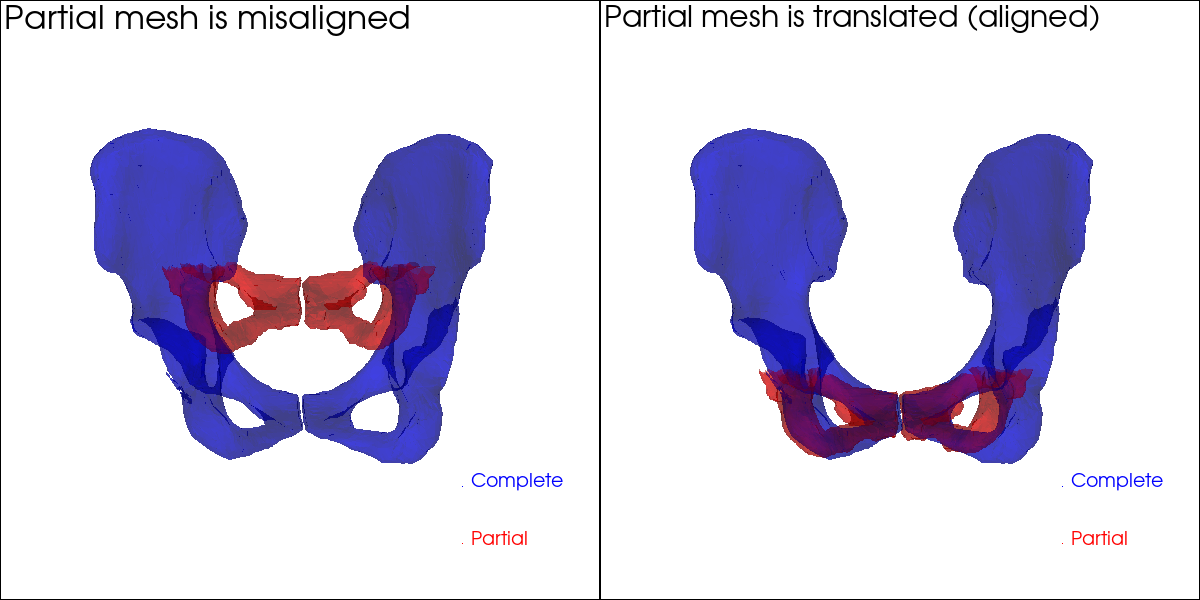

In [16]:
# Lucas - 2023/01/04
# Check the incomplete data before processing data

def translate_mesh(mesh, translation_vector):
    """
    Lucas - 2023/01/04
    Translate a mesh by a given vector.
    Based on: https://docs.pyvista.org/version/stable/api/core/_autosummary/pyvista.DataSet.translate.html
    
    Parameters:
    mesh: mesh points (verticises)
    tranalation_vector: [x,y,z] vector indicating the direction of translation 
    
    Returns:
    The translated mesh.
    """
    mesh = mesh.copy()
    mesh.translate(translation_vector, inplace=True, transform_all_input_vectors=False)
    return mesh

# Load your meshes
mesh1 = pv.read('../Assignment1/pelvis_dataset/Patient_0061.vtk')  
mesh2 = pv.read('../Assignment1/pelvis_dataset/Patient_0381.vtk')  

# Lucas - 2023/01/04
# point1 and point2 are the coordinates of the displacement necessary to align
# the incomplete mesh and the averaged mesh as shonw in the previous plot
# this points were obtained by visual inspection (manually selected)point1 = [5, -42, -67] 
point1 = [5, -42, -67]
point2 = [7, -41, 0] 

# Calculate the translation vector
translation_vector = np.array(point1) - np.array(point2)

# Translate mesh2
mesh2_translated = translate_mesh(mesh2, translation_vector)

# Now you can visualize the meshes to confirm their alignment
# pv.set_jupyter_backend('trame') 
plotter = pv.Plotter(shape=(1, 2), window_size=(1200,600), off_screen=True)

plotter.subplot(0, 0)
plotter.add_mesh(mesh1, color='blue', show_edges=False, opacity=0.5, label='Complete')
plotter.add_mesh(mesh2, color='red', show_edges=False, opacity=0.5, label='Partial')
plotter.add_legend(bcolor='w', face=None, loc='lower right')
plotter.add_text("Partial mesh is misaligned")
set_camera_view_position(plotter, view='y')

plotter.subplot(0, 1)
plotter.add_mesh(mesh1, color='blue', show_edges=False, opacity=0.5, label='Complete')
plotter.add_mesh(mesh2_translated, color='red', show_edges=False, opacity=0.5, label='Partial')
plotter.add_legend(bcolor='w', face=None, loc='lower right')
plotter.add_text("Partial mesh is translated (aligned)")
set_camera_view_position(plotter, view='y')

plotter.show()
plotter.screenshot(f'../OUTPUT/assignemnt_1_4_misaligned_shapes.png')
plotter.close()

### As shown above, the data of partial meshs is misaligned. We preprocess it to translate to the same point before performing the completition estimation.

In [19]:
# Lucas - 2023/01/04
# Compute the incomplete shape estimation
# Step by step:
# 1 - Load all data
# 2 - Perform PCA, you can set the number of components
# 3 - Build the model using the optimizer and scheduler setting up the gradients
# 4 - Build the reconstructed shape using the average mesha and the weights
# 5 - Compute the loss within the training loop between reconstructed and partial mesh, and update the wighths
# 6 - Agter training, rebuild the complete mesh
# 7 - Plot

def compute_nearest_point_distance_torch(mesh1, mesh2, batch_size=512):
    """
    Lucas - 2023/01/04
    Compute the Euclidean distance between the nearest points of two meshes using PyTorch with batch processing.
    Using torch to speed up process withou GPU. Batch size is supposed to improve processing.

    Based on:
    https://pytorch.org/docs/stable/generated/torch.cdist.html
    https://stackoverflow.com/questions/63727907/in-pytorch-calc-euclidean-distance-instead-of-matrix-multiplication
    https://qiita.com/k-morii-toridai/items/8ca9ada3420eaa6b9d0c
    
    Parameters:
    mesh1 (torch.Tensor): The points of the first mesh.
    mesh2 (torch.Tensor): The points of the second mesh.
    batch_size (int): The size of each batch for processing.
    
    Returns:
    torch.Tensor: The mean Euclidean distance between the nearest points of the meshes, as the Tip in the exercise.
    """
    min_distances = []

    # Lucas - 2023/01/04
    # Process mesh1 in batches for speed
    for i in range(0, len(mesh1), batch_size):
        batch1 = mesh1[i:i + batch_size]
        distances = torch.cdist(batch1, mesh2)
        min_dist_1, _ = distances.min(dim=1)
        min_distances.append(min_dist_1)

    # Lucas - 2023/01/04
    # Process mesh2 in batches for speed
    for i in range(0, len(mesh2), batch_size):
        batch2 = mesh2[i:i + batch_size]
        distances = torch.cdist(mesh1, batch2)
        min_dist_2, _ = distances.min(dim=0)
        min_distances.append(min_dist_2)

    # Lucas - 2023/01/04
    # Combine the distances and compute the mean (concatenation)
    # Based on: https://pytorch.org/docs/stable/generated/torch.cat.html
    combined_distances = torch.cat(min_distances)
    
    return combined_distances.mean()

def reconstruction_loss_torch(weights, mean_shape, 
                              pca_components, pca_variance, 
                              partial_mesh_points,
                              num_points):
    """
    Lucas - 2023/01/04
    PyTorch compatible function to compute reconstruction loss with n principal components.
    based on:
        https://medium.com/@megha.natarajan/performing-principle-component-analysis-pca-in-pytorch-why-and-how-777cfcde032a
        https://pytorch.org/docs/stable/generated/torch.sort.html
        https://qiita.com/awawaInu/items/0aec98192b120a2ae65f
    
    Parameters:
    weights (torch.Tensor): Weights for each principal component.
    mean_shape (torch.Tensor): The mean shape of the data.
    pca_components (torch.Tensor): Principal components of the data.
    pca_variance (torch.Tensor): Variance explained by each principal component.
    partial_mesh_points (torch.Tensor): Points of the partial mesh for reconstruction comparison.
    
    Returns:
    torch.Tensor: The total reconstruction loss.
    """
    # Reshape the mean shape to 3D
    mean_shape_reshaped = mean_shape.view(-1, 3)

    # Initialize reconstruction with mean shape
    Xq = mean_shape_reshaped.clone()

    # Add contribution of each principal component based on the corresponding weight
    # Here we can have a vector with as many PCA components as we want
    for i in range(len(weights)):
        comp_i_3d = pca_components[i].view(-1, 3)
        Xq += weights[i] * comp_i_3d * torch.sqrt(pca_variance[i])

    # Lucas - 2023/01/04
    # Sort and trim Xq based on the Z-axis to make sure we compute distance only
    # between the parts of the incomplete shape and the respective part in the complete 
    # shape, not over all the complete shape
    # the trim is used to make sure we compute distance between meshes of same size
    # if not we get a broadcast error
    _, indices = torch.sort(Xq[:, 2], descending=True)
    Xq_trimmed = Xq[indices][-num_points:, :]

    # Compute the distance
    full_distance = compute_nearest_point_distance_torch(partial_mesh_points, Xq_trimmed)

    # Lucas - 2023/01/04
    # Compute a penalty term for deviation in the overlapping region
    # This penalty helps improve reconstruction a little bit
    # Based on: https://stackoverflow.com/questions/58560717/calculate-euclidean-distance-for-three-means
    overlapping_distance = torch.sqrt(torch.sum((partial_mesh_points - Xq_trimmed) ** 2, dim=1)).mean()

    # # Combine the distances with a weighting factor for the penalty
    # alpha = 0.50  # Weighting factor
    # total_loss = full_distance + alpha * overlapping_distance
    # total_loss = full_distance

    return full_distance
    
# Lucas - 2023/01/04
# this allows iteractive plot, but can be removed if the notebook doesn't support it
# pv.set_jupyter_backend('trame') 

# Lucas - 2023/01/04
# Read partial mesh and determine the criteria for filtering
vtk_folder_path = "../Assignment1/pelvis_dataset/"
patient_id = "Patient_0400"
partial_mesh_path = f"{vtk_folder_path}{patient_id}.vtk"
partial_mesh = pv.read(partial_mesh_path)
partial_mesh_points = partial_mesh.points
num_points = partial_mesh.points.shape[0] # use this to trim data within reconstruction_loss_torch

# Read all meshes and store them in a list to perform PCA later
all_meshes = []
for patient in patient_data_list:
    mesh = patient['mesh']
    flattened_points = mesh.points.flatten()
    all_meshes.append(flattened_points)

# Stack all flattened meshes to create the data matrix for PCA
A = np.column_stack(all_meshes)

# Perform PCA with a dynamic number of components, testing with 50 for now
n_components = 50
pca = PCA(n_components=n_components)
pca.fit(A.T)

# Extract PCA results
mean_shape = pca.mean_
components = pca.components_
explained_variance = pca.explained_variance_

# Lucas - 2023/01/04
# point1 and point2 are the coordinates of the displacement necessary to align
# the incomplete mesh and the averaged mesh as shonw in the previous plot
# this points were obtained by visual inspection (manually selected)
point1 = [5, -42, -67]
point2 = [7, -41, 0]
# compuite the translation vector
translation_vector = np.array(point1) - np.array(point2)

# store the vertices points of the partial mesh
# this is the reference we will use to adjust the weights
# the objective is for the weights to best approximate this shape
partial_mesh_translated = translate_mesh(partial_mesh, translation_vector)
partial_mesh_points = partial_mesh_translated.points  # shape: (num_points, 3)

# Convert arrays to PyTorch tensors
mean_shape_torch = torch.tensor(mean_shape, dtype=torch.float32)
components_torch = torch.tensor(components[:n_components], dtype=torch.float32)  # Use only the first n_components
explained_variance_torch = torch.tensor(explained_variance[:n_components], dtype=torch.float32) # Use only the first n_components
partial_mesh_points_torch = torch.tensor(partial_mesh_points, dtype=torch.float32)


# Lucas - 2023/01/04
# Optimization loop
# for each iteraction:
# 1 - compute the loss between mean shape with weights and incomplete mesh
# 2 - update weights
# 3 - repeat for num_epochs
# During trainig, decrease the learning rate using the scheduler to improve convergence
# based on: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

num_epochs = 2000

# Define weights as a PyTorch tensor with requires_grad=True, matching the number of components
# Load the saved state dictionary
checkpoint = torch.load(f'../OUTPUT/reconstruction_model_components_{patient_id}_1500_epochs_{n_components}_PCA.pth')
# Extract the optimized weights
loaded_weights = checkpoint['optimized_weights']
loaded_weights = torch.tensor(loaded_weights, dtype=torch.float32)
loaded_weights.requires_grad_(True)
# weights = torch.zeros(n_components, requires_grad=True)
weights = loaded_weights


# Setup the optimizer
optimizer = torch.optim.Adam([weights], lr=0.005)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)


for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = reconstruction_loss_torch(weights, mean_shape_torch, components_torch, explained_variance_torch, partial_mesh_points_torch, num_points)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Recover training data as numpy array
mean_shape = mean_shape_torch.detach().numpy()
optimized_weights = weights.detach().numpy()
components = components_torch.detach().numpy()
explained_variance = explained_variance_torch.detach().numpy()

# Reconstruct X_q with optimized weights
Xq_optimized = mean_shape_torch.reshape(-1, 3).detach().numpy().copy()
for i in range(len(optimized_weights)):
    Xq_optimized += optimized_weights[i] * components[i].reshape(-1, 3) * np.sqrt(explained_variance[i])

# Save these components
torch.save({
    'optimized_weights': optimized_weights,
    'mean_shape': mean_shape,
    'components': components,
    'explained_variance': explained_variance
}, f'../OUTPUT/reconstruction_model_components_{patient_id}_{num_epochs}_epochs_{n_components}_PCA.pth')

print("Finished training")

Epoch 0, Loss: 4.465963840484619
Epoch 100, Loss: 2.4770965576171875
Epoch 200, Loss: 2.146256923675537
Epoch 300, Loss: 2.05937123298645
Epoch 400, Loss: 2.0175352096557617
Epoch 500, Loss: 1.9709808826446533
Epoch 600, Loss: 1.9466712474822998
Epoch 700, Loss: 1.9278141260147095
Epoch 800, Loss: 1.9108366966247559
Epoch 900, Loss: 1.898199439048767
Epoch 1000, Loss: 1.8917665481567383
Epoch 1100, Loss: 1.8867532014846802
Epoch 1200, Loss: 1.8827414512634277
Epoch 1300, Loss: 1.879553198814392
Epoch 1400, Loss: 1.8751475811004639
Epoch 1500, Loss: 1.8720868825912476
Epoch 1600, Loss: 1.8704049587249756
Epoch 1700, Loss: 1.8674325942993164
Epoch 1800, Loss: 1.8651772737503052
Epoch 1900, Loss: 1.8629412651062012
Finished training


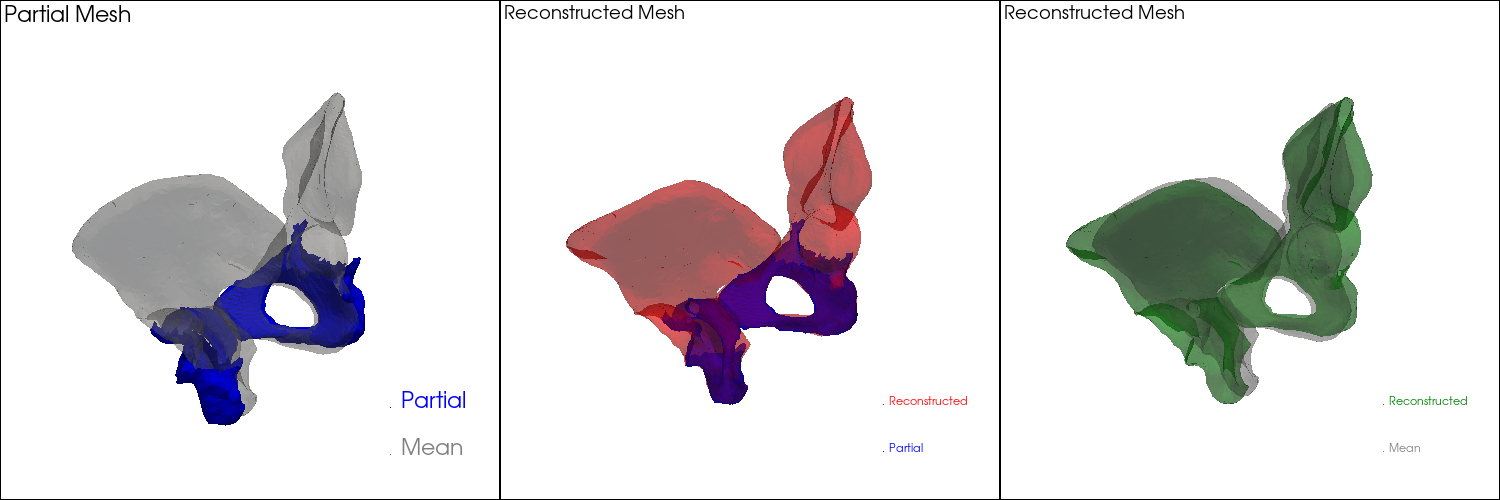

In [20]:
# Lucas - 2023/01/04
# Plot the results
reconstructed_mesh = pv.PolyData(Xq_optimized, mesh.faces)

# Plot the average mesh over both partial and reconstruction
mean_shape_reshaped = mean_shape_torch.reshape(-1, 3).detach().numpy()
reconstructed_mean = pv.PolyData(mean_shape_reshaped, partial_mesh.faces)
reconstructed_mean = patient_data_list[0]['mesh']

translated_partial_mesh = translate_mesh(partial_mesh, translation_vector)
translated_reconstructed_mesh = translate_mesh(reconstructed_mesh, translation_vector)

pv.set_jupyter_backend('static') # remove if problem to plot

plotter = pv.Plotter(shape=(1, 3), window_size=(1500,500))

# Plot the partial mesh
plotter.subplot(0, 0)
plotter.add_mesh(translated_partial_mesh, color='blue', show_edges=False, label='Partial')
plotter.add_mesh(reconstructed_mean, color='gray', show_edges=False, opacity=0.3, label='Mean')
plotter.add_text("Partial Mesh", font_size=10)
plotter.add_legend(bcolor='w', face=None, loc='lower right')

# Plot the reconstructed mesh and the partial, for comparission
plotter.subplot(0, 1)
plotter.add_mesh(reconstructed_mesh, color='red', show_edges=False, opacity=0.4, label='Reconstructed')
plotter.add_mesh(translated_partial_mesh, color='blue', show_edges=False, opacity=0.8, label='Partial')
plotter.add_text("Reconstructed Mesh", font_size=10)
plotter.add_legend(bcolor='w', face=None, loc='lower right')

# Plot the reconstructed mesh and the partial, for comparission
plotter.subplot(0, 2)
plotter.add_mesh(reconstructed_mesh, color='green', show_edges=False, opacity=0.4, label='Reconstructed')
plotter.add_mesh(reconstructed_mean, color='gray', show_edges=False, opacity=0.3, label='Mean')
plotter.add_text("Reconstructed Mesh", font_size=10)
plotter.add_legend(bcolor='w', face=None, loc='lower right')

# Display the plotter
plotter.show()
plotter.screenshot(f'../OUTPUT/assignemnt_1_4_reconstruction.png')
plotter.close()